This notebook wants to make use of the Pipeline previously designed to efficiently test and evaluate a model in order to get actionable insights about its performance

In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit, KFold, GridSearchCV, learning_curve

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('max_columns', 500)

In [3]:
def make_test(train, test_size, random_state, strat_feat=None):
    if strat_feat:
        
        split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)

        for train_index, test_index in split.split(train, train[strat_feat]):
            train_set = train.loc[train_index]
            test_set = train.loc[test_index]
            
    return train_set, test_set

# Data preparation

Get the data ready to flow into the pipeline

In [4]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

df_train['Target'] = np.log1p(df_train.SalePrice)

del df_train['SalePrice']

train_set, test_set = make_test(df_train, 
                                test_size=0.2, random_state=654, 
                                strat_feat='Neighborhood')

y = train_set['Target'].copy()
del train_set['Target']

y_test = test_set['Target']
del test_set['Target']

## Building the pipeline

This was introduced in another notebook

In [31]:
class feat_sel(BaseEstimator, TransformerMixin):
    '''
    This transformer selects either numerical or categorical features.
    In this way we can build separate pipelines for separate data types.
    '''
    def __init__(self, dtype='numeric'):
        self._dtype = dtype

    def fit( self, X, y=None ):
        return self 

    def transform(self, X, y=None):
        if self._dtype == 'numeric':
            num_cols = X.columns[X.dtypes != object].tolist()
            return X[num_cols]
        elif self._dtype == 'category':
            cat_cols = X.columns[X.dtypes == object].tolist()
            return X[cat_cols]


class df_imputer(TransformerMixin):
    '''
    Just a wrapper for the SimpleImputer that keeps the dataframe structure
    '''
    def __init__(self, strategy='mean'):
        self.strategy = strategy
        self.imp = None
        self.statistics_ = None

    def fit(self, X, y=None):
        self.imp = SimpleImputer(strategy=self.strategy)
        self.imp.fit(X)
        self.statistics_ = pd.Series(self.imp.statistics_, index=X.columns)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Ximp = self.imp.transform(X)
        Xfilled = pd.DataFrame(Ximp, index=X.index, columns=X.columns)
        return Xfilled

    
class df_scaler(TransformerMixin):
    '''
    Wrapper of StandardScaler or RobustScaler
    '''
    def __init__(self, method='standard'):
        self.scl = None
        self.scale_ = None
        self.method = method
        if self.method == 'sdandard':
            self.mean_ = None
        elif method == 'robust':
            self.center_ = None
        self.columns = None  # this is useful when it is the last step of a pipeline before the model

    def fit(self, X, y=None):
        if self.method == 'standard':
            self.scl = StandardScaler()
            self.scl.fit(X)
            self.mean_ = pd.Series(self.scl.mean_, index=X.columns)
        elif self.method == 'robust':
            self.scl = RobustScaler()
            self.scl.fit(X)
            self.center_ = pd.Series(self.scl.center_, index=X.columns)
        self.scale_ = pd.Series(self.scl.scale_, index=X.columns)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xscl = self.scl.transform(X)
        Xscaled = pd.DataFrame(Xscl, index=X.index, columns=X.columns)
        self.columns = X.columns
        return Xscaled

    def get_feature_names(self):
        return list(self.columns)
    
    
class dummify(TransformerMixin):
    '''
    Wrapper for get dummies
    '''
    def __init__(self, drop_first=False):
        self.drop_first = drop_first
        self.columns = []  # useful to well behave with FeatureUnion

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = pd.get_dummies(X, drop_first=self.drop_first)
        self.columns = X.columns
        return X
    
    def get_features_name(self):
        return self.columns

    
class general_cleaner(BaseEstimator, TransformerMixin):
    '''
    This class applies what we know from the documetation.
    It cleans some known missing values
    If flags the missing values

    This process is supposed to happen as first step of any pipeline

    TODO: decide how to drop the outliers as the target is created before this point
    '''
    def __init__(self, train=True):
        self._train = train
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        #LotFrontage
        X.loc[X.LotFrontage.isnull(), 'LotFrontage'] = 0
        #Alley
        X.loc[X.Alley.isnull(), 'Alley'] = "NoAlley"
        #MSSubClass
        X['MSSubClass'] = X['MSSubClass'].astype(str)
        #MissingBasement
        fil = ((X.BsmtQual.isnull()) & (X.BsmtCond.isnull()) & (X.BsmtExposure.isnull()) &
              (X.BsmtFinType1.isnull()) & (X.BsmtFinType2.isnull()))
        fil1 = ((X.BsmtQual.notnull()) | (X.BsmtCond.notnull()) | (X.BsmtExposure.notnull()) |
              (X.BsmtFinType1.notnull()) | (X.BsmtFinType2.notnull()))
        X.loc[fil1, 'MisBsm'] = 0
        X.loc[fil, 'MisBsm'] = 1 # made explicit for safety
        #BsmtQual
        X.loc[fil, 'BsmtQual'] = "NoBsmt" #missing basement
        #BsmtCond
        X.loc[fil, 'BsmtCond'] = "NoBsmt" #missing basement
        #BsmtExposure
        X.loc[fil, 'BsmtExposure'] = "NoBsmt" #missing basement
        #BsmtFinType1
        X.loc[fil, 'BsmtFinType1'] = "NoBsmt" #missing basement
        #BsmtFinType2
        X.loc[fil, 'BsmtFinType2'] = "NoBsmt" #missing basement
        #BsmtFinSF1
        X.loc[fil, 'BsmtFinSF1'] = 0 # No bsmt
        #BsmtFinSF2
        X.loc[fil, 'BsmtFinSF2'] = 0 # No bsmt
        #BsmtUnfSF
        X.loc[fil, 'BsmtUnfSF'] = 0 # No bsmt
        #TotalBsmtSF
        X.loc[fil, 'TotalBsmtSF'] = 0 # No bsmt
        #BsmtFullBath
        X.loc[fil, 'BsmtFullBath'] = 0 # No bsmt
        #BsmtHalfBath
        X.loc[fil, 'BsmtHalfBath'] = 0 # No bsmt
        #FireplaceQu
        X.loc[(X.Fireplaces == 0) & (X.FireplaceQu.isnull()), 'FireplaceQu'] = "NoFire" #missing
        #MisGarage
        fil = ((X.GarageYrBlt.isnull()) & (X.GarageType.isnull()) & (X.GarageFinish.isnull()) &
              (X.GarageQual.isnull()) & (X.GarageCond.isnull()))
        fil1 = ((X.GarageYrBlt.notnull()) | (X.GarageType.notnull()) | (X.GarageFinish.notnull()) |
              (X.GarageQual.notnull()) | (X.GarageCond.notnull()))
        X.loc[fil1, 'MisGarage'] = 0
        X.loc[fil, 'MisGarage'] = 1
        #GarageYrBlt
        X.loc[X.GarageYrBlt > 2200, 'GarageYrBlt'] = 2007 #correct mistake
        X.loc[fil, 'GarageYrBlt'] = 0
        #GarageType
        X.loc[fil, 'GarageType'] = "NoGrg" #missing garage
        #GarageFinish
        X.loc[fil, 'GarageFinish'] = "NoGrg" #missing
        #GarageQual
        X.loc[fil, 'GarageQual'] = "NoGrg" #missing
        #GarageCond
        X.loc[fil, 'GarageCond'] = "NoGrg" #missing
        #Fence
        X.loc[X.Fence.isnull(), 'Fence'] = "NoFence" #missing fence
        #Pool
        fil = ((X.PoolArea == 0) & (X.PoolQC.isnull()))
        X.loc[fil, 'PoolQC'] = 'NoPool' 
        
        del X['Id']
        del X['MiscFeature']
        del X['MSSubClass']
        del X['Neighborhood']  # this should be useful
        del X['Condition1']
        del X['Condition2']
        del X['ExterCond']  # maybe ordinal
        del X['Exterior1st']
        del X['Exterior2nd']
        del X['Functional']
        del X['Heating']
        del X['PoolQC']
        del X['RoofMatl']
        del X['RoofStyle']
        del X['SaleCondition']
        del X['SaleType']
        del X['Utilities']
        del X['BsmtCond']
        del X['Electrical']
        del X['Foundation']
        del X['Street']
        del X['Fence']
        del X['LandSlope']
        
        return X
    
class tr_numeric(BaseEstimator, TransformerMixin):
    def __init__(self, SF_room=True, bedroom=True, bath=True, lot=True, service=True):
        self.columns = []  # useful to well behave with FeatureUnion
        self.SF_room = SF_room
        self.bedroom = bedroom
        self.bath = bath
        self.lot = lot
        self.service = service
     

    def fit(self, X, y=None):
        return self
    

    def remove_skew(self, X, column):
        X[column] = np.log1p(X[column])
        return X


    def SF_per_room(self, X):
        if self.SF_room:
            X['sf_per_room'] = X['GrLivArea'] / X['TotRmsAbvGrd']
        return X


    def bedroom_prop(self, X):
        if self.bedroom:
            X['bedroom_prop'] = X['BedroomAbvGr'] / X['TotRmsAbvGrd']
            del X['BedroomAbvGr'] # the new feature makes it redundant and it is not important
        return X


    def total_bath(self, X):
        if self.bath:
            X['total_bath'] = (X[[col for col in X.columns if 'FullBath' in col]].sum(axis=1) +
                             0.5 * X[[col for col in X.columns if 'HalfBath' in col]].sum(axis=1))
            del X['FullBath']  # redundant 

        del X['HalfBath']  # not useful anyway
        del X['BsmtHalfBath']
        del X['BsmtFullBath']
        return X


    def lot_prop(self, X):
        if self.lot:
            X['lot_prop'] = X['LotArea'] / X['GrLivArea']
        return X 


    def service_area(self, X):
        if self.service:
            X['service_area'] = X['TotalBsmtSF'] + X['GarageArea']
            del X['TotalBsmtSF']
            del X['GarageArea']
        return X
    

    def transform(self, X, y=None):
        for col in ['GrLivArea', '1stFlrSF', 'LotArea']:
            X = self.remove_skew(X, col)

        X = self.SF_per_room(X)
        X = self.bedroom_prop(X)
        X = self.total_bath(X)
        X = self.lot_prop(X)
        X = self.service_area(X)

        self.columns = X.columns
        return X
    

    def get_features_name(self):
        return self.columns
    
    
class make_ordinal(BaseEstimator, TransformerMixin):
    '''
    Transforms ordinal features in order to have them as numeric (preserving the order)
    If unsure about converting or not a feature (maybe making dummies is better), make use of
    extra_cols and unsure_conversion
    '''
    def __init__(self, cols, extra_cols=None, include_extra=True):
        self.cols = cols
        self.extra_cols = extra_cols
        self.mapping = {'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
        self.include_extra = include_extra
    

    def fit(self, X, y=None):
        return self
    

    def transform(self, X, y=None):
        if self.extra_cols:
            if self.include_extra:
                self.cols += self.extra_cols
            else:
                for col in self.extra_cols:
                    del X[col]
        
        for col in self.cols:
            X.loc[:, col] = X[col].map(self.mapping).fillna(0)
        return X


class recode_cat(BaseEstimator, TransformerMixin):        
    '''
    Recodes some categorical variables according to the insights gained from the
    data exploration phase.
    '''
    def fit(self, X, y=None):
        return self
    
    
    def tr_GrgType(self, data):
        data['GarageType'] = data['GarageType'].map({'Basment': 'Attchd',
                                                  'CarPort': 'Detchd', 
                                                  '2Types': 'Attchd' }).fillna(data['GarageType'])
        return data
    
    
    def tr_LotShape(self, data):
        fil = (data.LotShape != 'Reg')
        data['LotShape'] = 1
        data.loc[fil, 'LotShape'] = 0
        return data
    
    
    def tr_LandCont(self, data):
        fil = (data.LandContour == 'HLS') | (data.LandContour == 'Low')
        data['LandContour'] = 0
        data.loc[fil, 'LandContour'] = 1
        return data
    
    
    def tr_LandSlope(self, data):
        fil = (data.LandSlope != 'Gtl')
        data['LandSlope'] = 0
        data.loc[fil, 'LandSlope'] = 1
        return data
    
    
    def tr_MSZoning(self, data):
        data['MSZoning'] = data['MSZoning'].map({'RH': 'RM', # medium and high density
                                                 'C (all)': 'RM', # commercial and medium density
                                                 'FV': 'RM'}).fillna(data['MSZoning'])
        return data
    
    
    def tr_Alley(self, data):
        fil = (data.Alley != 'NoAlley')
        data['Alley'] = 0
        data.loc[fil, 'Alley'] = 1
        return data
    
    
    def tr_LotConfig(self, data):
        data['LotConfig'] = data['LotConfig'].map({'FR3': 'Corner', # corners have 2 or 3 free sides
                                                   'FR2': 'Corner'}).fillna(data['LotConfig'])
        return data
    
    
    def tr_BldgType(self, data):
        data['BldgType'] = data['BldgType'].map({'Twnhs' : 'TwnhsE',
                                                 '2fmCon': 'Duplex'}).fillna(data['BldgType'])
        return data
    
    
    def tr_MasVnrType(self, data):
        data['MasVnrType'] = data['MasVnrType'].map({'BrkCmn': 'BrkFace'}).fillna(data['MasVnrType'])
        return data


    def tr_HouseStyle(self, data):
        data['HouseStyle'] = data['HouseStyle'].map({'1.5Fin': '1.5Unf', 
                                                         '2.5Fin': '2Story', 
                                                         '2.5Unf': '2Story', 
                                                         'SLvl': 'SFoyer'}).fillna(data['HouseStyle'])
        return data
    
    
    def transform(self, X, y=None):
        X = self.tr_GrgType(X)
        X = self.tr_LotShape(X)
        X = self.tr_LotConfig(X)
        X = self.tr_MSZoning(X)
        X = self.tr_Alley(X)
        # X = self.tr_LandSlope(X)
        X = self.tr_LandCont(X)
        X = self.tr_BldgType(X)
        X = self.tr_MasVnrType(X)
        X = self.tr_HouseStyle(X)
        return X

    
    
class FeatureUnion_df(TransformerMixin, BaseEstimator):
    '''
    Wrapper of FeatureUnion but returning a Dataframe, 
    the column order follows the concatenation done by FeatureUnion

    transformer_list: list of Pipelines

    '''
    def __init__(self, transformer_list, n_jobs=None, transformer_weights=None, verbose=False):
        self.transformer_list = transformer_list
        self.n_jobs = n_jobs
        self.transformer_weights = transformer_weights
        self.verbose = verbose  # these are necessary to work inside of GridSearch or similar
        self.feat_un = FeatureUnion(self.transformer_list, 
                                    self.n_jobs, 
                                    self.transformer_weights, 
                                    self.verbose)
        
    def fit(self, X, y=None):
        self.feat_un.fit(X)
        return self

    def transform(self, X, y=None):
        X_tr = self.feat_un.transform(X)
        columns = []
        
        for trsnf in self.transformer_list:
            cols = trsnf[1].steps[-1][1].get_features_name()
            columns += list(cols)

        X_tr = pd.DataFrame(X_tr, index=X.index, columns=columns)
        
        return X_tr

    def get_params(self, deep=True):  # necessary to well behave in GridSearch
        return self.feat_un.get_params(deep=deep)


In [32]:
numeric_pipe = Pipeline([('fs', feat_sel('numeric')),
                         ('imputer', df_imputer(strategy='median')),
                         ('transf', tr_numeric())])


cat_pipe = Pipeline([('fs', feat_sel('category')),
                     ('imputer', df_imputer(strategy='most_frequent')), 
                     ('ord', make_ordinal(['BsmtQual', 'KitchenQual','GarageQual',
                                           'GarageCond', 'ExterQual', 'HeatingQC'])), 
                     ('recode', recode_cat()), 
                     ('dummies', dummify(drop_first=True))])


processing_pipe = FeatureUnion_df(transformer_list=[('cat_pipe', cat_pipe),
                                                    ('num_pipe', numeric_pipe)])

## Evaluation method

First of all, I want to be able to evaluate my model using kfold cross validation. To do so, I need to create an oof prediction from these folds.

In [33]:
def cv_score(df_train, y_train, kfolds, pipeline):
    oof = np.zeros(len(df_train))
    train = df_train.copy()
    
    for train_index, test_index in kfolds.split(train.values):
            
        trn_data = train.iloc[train_index][:]
        val_data = train.iloc[test_index][:]
        
        trn_target = y_train.iloc[train_index].values.ravel()
        val_target = y_train.iloc[test_index].values.ravel()
        
        pipeline.fit(trn_data, trn_target)

        oof[test_index] = pipeline.predict(val_data).ravel()
            
    return oof

In [44]:
folds = KFold(5, shuffle=True, random_state=541)

lasso_pipe = Pipeline([('gen_cl', general_cleaner()), 
                 ('processing', processing_pipe),
                  ('scl', df_scaler()), ('lasso', Lasso(alpha=0.01))])

lasso_oof = cv_score(train_set, y, folds, lasso_pipe)

lasso_oof[:10]

array([11.33709735, 12.03371315, 12.09504158, 11.84571507, 11.80633294,
       12.59302308, 12.60162385, 12.36724327, 12.18336355, 12.07553761])

Perfect! Now I want to be able to see what role each feature is playing in our model. Most of the efforts made to make the pipeline preserve the dataframe structure were due to this step.

In [45]:
def get_coef(pipe):
    imp = pipe.steps[-1][1].coef_.tolist()
    feats = pipe.steps[-2][1].get_feature_names()
    result = pd.DataFrame({'feat':feats,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result


def get_feature_importance(pipe):
    imp = pipe.steps[-1][1].feature_importances_.tolist() #it's a pipeline
    feats = pipe.steps[-2][1].get_feature_names()
    result = pd.DataFrame({'feat':feats,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result

In [46]:
get_coef(lasso_pipe)

,feat,score
62,GrLivArea,0.098195
51,OverallQual,0.096376
67,GarageCars,0.041336
4,BsmtQual,0.037546
50,LotArea,0.034762
...,...,...
63,KitchenAbvGr,-0.003769
38,FireplaceQu_NoFire,-0.005681
21,BsmtExposure_No,-0.006715
28,BsmtFinType1_Unf,-0.014217


The implementation for feature importance can be tested with another pipeline.

In [47]:
forest_pipe = Pipeline([('gen_cl', general_cleaner()), 
                 ('processing', processing_pipe),
                  ('scl', df_scaler()), ('forest', RandomForestRegressor(n_estimators=500, n_jobs=5))])

forest_oof = cv_score(train_set, y, folds, forest_pipe)

get_feature_importance(forest_pipe)

,feat,score
51,OverallQual,0.496346
83,service_area,0.141559
62,GrLivArea,0.106163
81,total_bath,0.042159
67,GarageCars,0.022189
...,...,...
32,BsmtFinType2_NoBsmt,0.000027
26,BsmtFinType1_NoBsmt,0.000023
77,MisBsm,0.000017
22,BsmtExposure_NoBsmt,0.000017


To be fair, these coefficients are referring to the last fit of the pipeline, thus only to the last fold. We will correct this later.

The next thing I want to check is how much the predictions and the true label are differing. To do so, I need to study the residual plots

In [51]:
def _plot_diagonal(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    low = min(xmin, xmax)
    high = max(xmin, xmax)
    scl = (high - low) / 100
    
    line = pd.DataFrame({'x': np.arange(low, high ,scl), # small hack for a diagonal line
                         'y': np.arange(low, high ,scl)})
    ax.plot(line.x, line.y, color='black', linestyle='--')
    
    return ax


def plot_predictions(data, true_label, pred_label, feature=None, hue=None, legend=False, savename='test.png'):
    
    tmp = data.copy()
    tmp['Prediction'] = pred_label
    tmp['True Label'] = true_label
    tmp['Residual'] = tmp['True Label'] - tmp['Prediction']
    
    diag = False
    alpha = 0.7
    label = ''
    
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    
    if feature is None:
        feature = 'True Label'
        diag = True
    else:
        legend = 'full'
        sns.scatterplot(x=feature, y='True Label', data=tmp, ax=ax[0], label='True',
                         hue=hue, legend=legend, alpha=alpha)
        label = 'Predicted'
        alpha = 0.4

    sns.scatterplot(x=feature, y='Prediction', data=tmp, ax=ax[0], label=label,
                         hue=hue, legend=legend, alpha=alpha)
    if diag:
        ax[0] = _plot_diagonal(ax[0])
    
    sns.scatterplot(x=feature, y='Residual', data=tmp, ax=ax[1], 
                    hue=hue, legend=legend, alpha=0.7)
    ax[1].axhline(y=0, color='r', linestyle='--')
    
    ax[0].set_title(f'{feature} vs Predictions')
    ax[1].set_title(f'{feature} vs Residuals')
    
    if not savename.endswith('.png'):
        savename += '.png'
    #plt.savefig('../plots/' + savename)
    #plt.close()

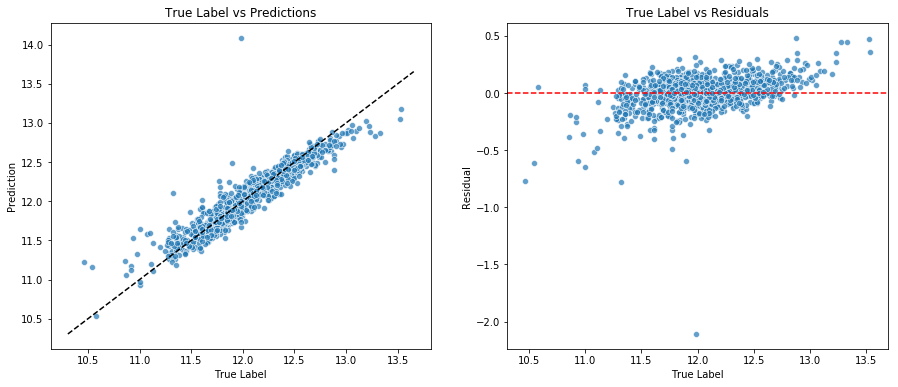

In [52]:
plot_predictions(train_set, y, lasso_oof)

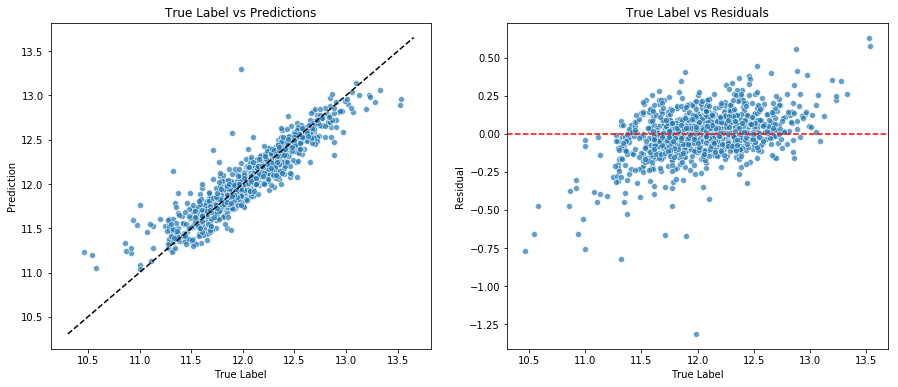

In [53]:
plot_predictions(train_set, y, forest_oof)

At last, I want to see some metrics and the residual plots for the most important features

In [55]:
def evaluate(data, y_true, y_pred, pipe, feat='coef', hue=None, legend=False, savename='test.png'):
    print(f'RMSE: {round(np.sqrt(mean_squared_error(y_true, y_pred)), 4)}')
    print(f'MAE: {round(mean_absolute_error(np.expm1(y_true), np.expm1(y_pred)), 4)}')
    
    plot_predictions(data, y_true, y_pred, hue=hue, legend=legend, savename=savename)
    
    if feat=='coef':
        imp_feat = get_coef(pipe)
    elif feat == 'imp':
        imp_feat = get_feature_importance(pipe)
    else:
        raise AttributeError('The attribute feat can either be coef or imp')
        
    imp_feat['abs'] = abs(imp_feat['score'])
    imp_feat = imp_feat.sort_values(by='abs', ascending=False).head()
    
    if savename.endswith('.png'):
        savename = savename.replace('.png', '_')
    
    for feat in imp_feat.feat:
        feat_savename = savename + feat + '.png'
        try:
            plot_predictions(data, y_true, y_pred, feature=feat,
                         hue=hue, legend=legend, savename=feat_savename)
        except KeyError:
            print(f'{feat} not present in the provided data, \
                  probably is generated by a transformation in the pipeline')

RMSE: 0.1413
MAE: 17744.0432


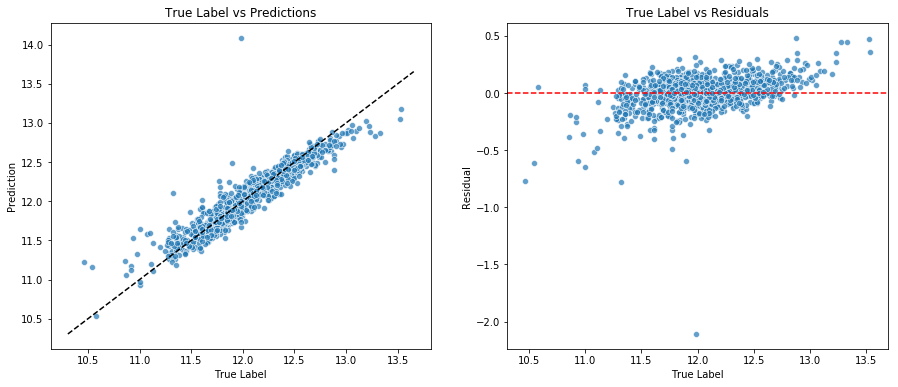

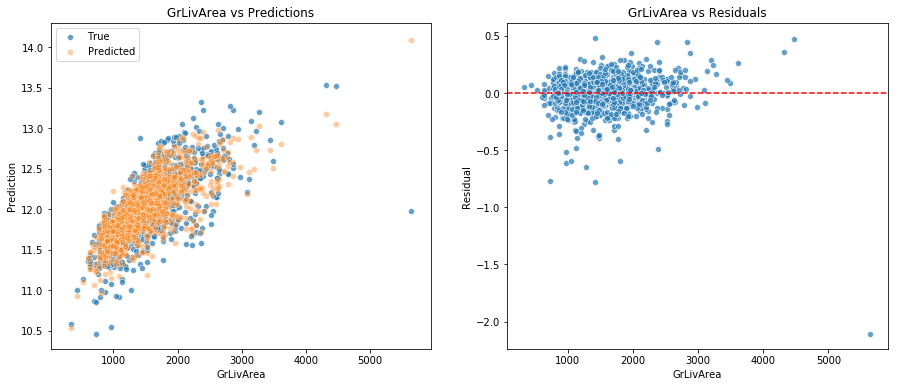

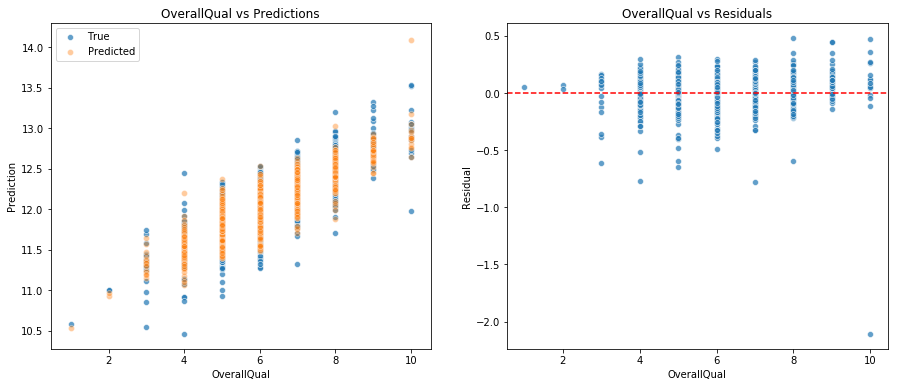

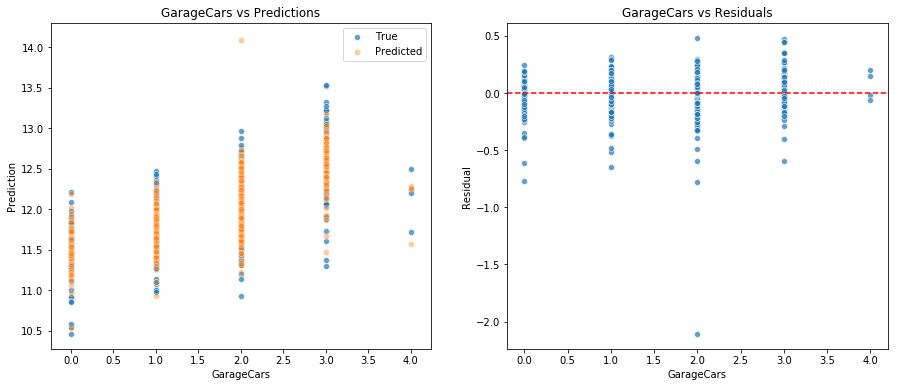

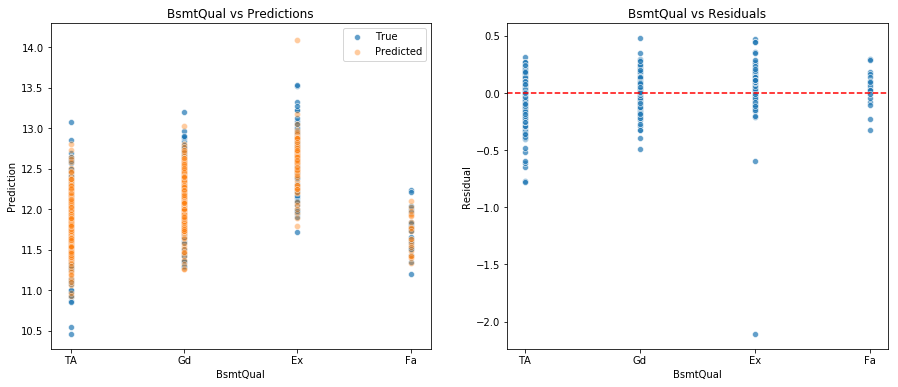

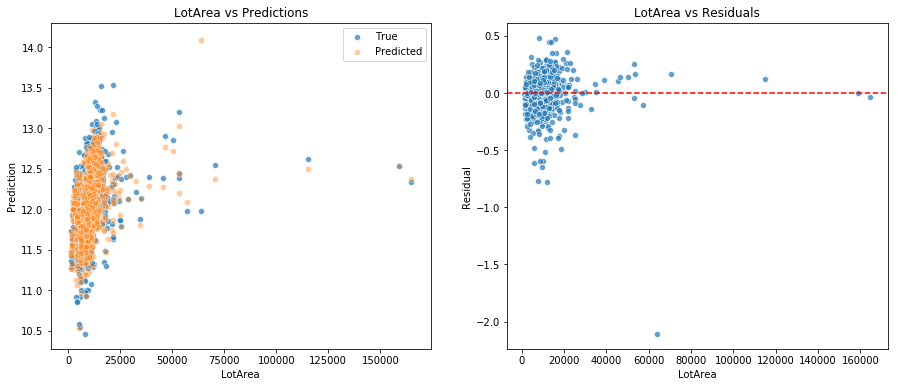

In [56]:
evaluate(train_set, y, lasso_oof, lasso_pipe)

RMSE: 0.1472
MAE: 18164.3598


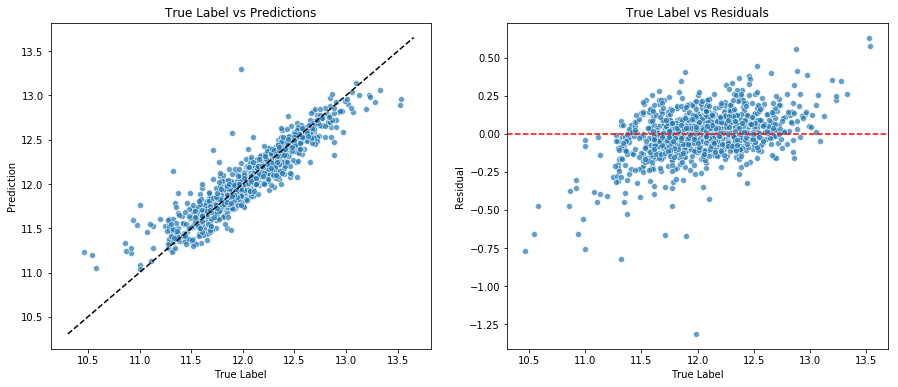

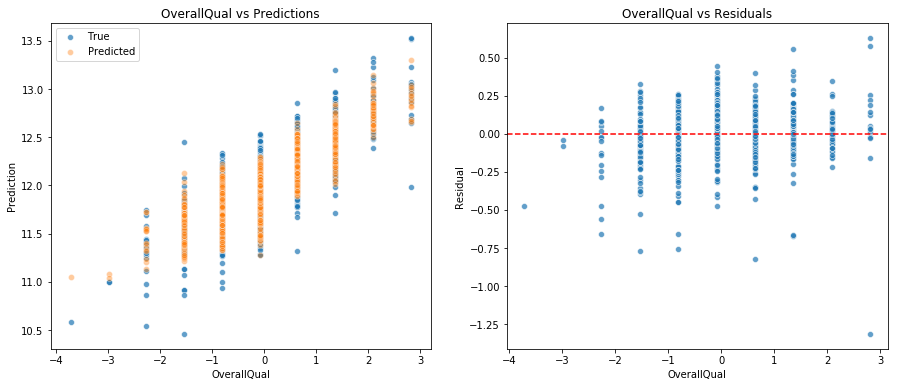

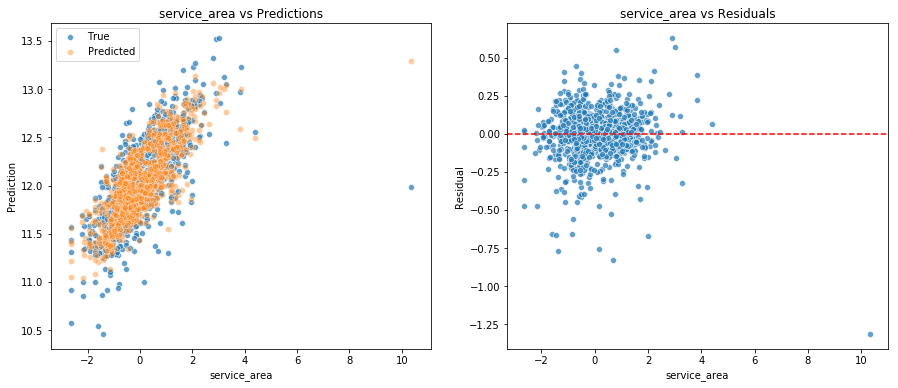

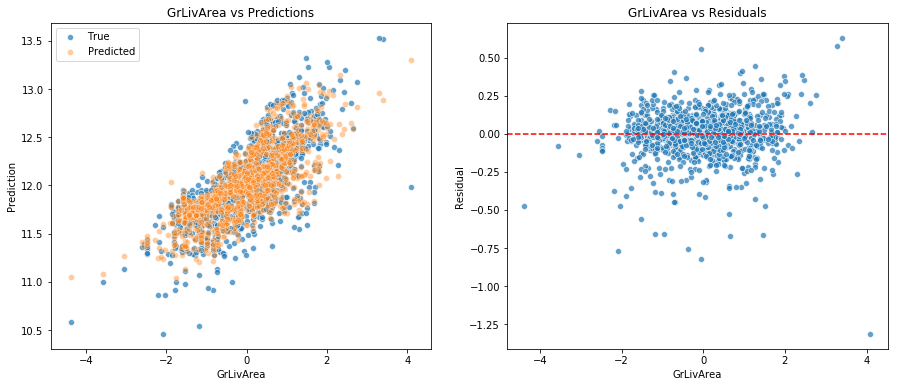

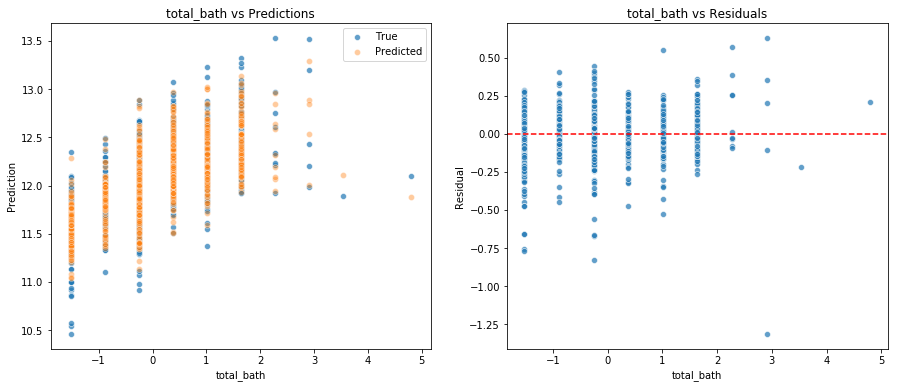

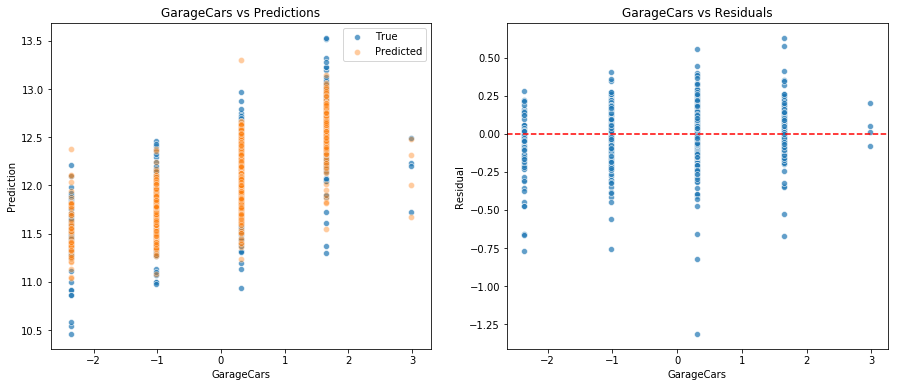

In [59]:
feat_pipe = Pipeline([('gen_cl', general_cleaner()), 
                 ('processing', processing_pipe),
                  ('scl', df_scaler())])

tmp = feat_pipe.fit_transform(train_set)

evaluate(tmp, y, forest_oof, forest_pipe, feat='imp')

In [208]:
pipe.get_params()

{'memory': None,
 'steps': [('gen_cl', general_cleaner(train=None)),
  ('processing', FeatureUnion_df(n_jobs=None,
                   transformer_list=[('cat_pipe',
                                      Pipeline(memory=None,
                                               steps=[('fs',
                                                       feat_sel(dtype='category')),
                                                      ('imputer',
                                                       df_imputer(strategy='most_frequent')),
                                                      ('ord',
                                                       make_ordinal(cols=['BsmtQual',
                                                                          'KitchenQual',
                                                                          'GarageQual',
                                                                          'GarageCond',
                                                         

In [209]:

grid = GridSearchCV(estimator=pipe, 
                    param_grid={'processing__num_pipe__imputer__strategy': ['mean', 'median']}, 
                    cv=folds, scoring='neg_mean_squared_error')


In [210]:
pd.options.mode.chained_assignment = None
tmp =train_set.copy()

grid = grid.fit(tmp, y)
pd.options.mode.chained_assignment = 'warn'

In [211]:
grid.cv_results_

{'mean_fit_time': array([0.13731532, 0.13532796]),
 'std_fit_time': array([0.00433885, 0.00116306]),
 'mean_score_time': array([0.09123611, 0.09115419]),
 'std_score_time': array([0.00040902, 0.00064305]),
 'param_processing__num_pipe__imputer__strategy': masked_array(data=['mean', 'median'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'processing__num_pipe__imputer__strategy': 'mean'},
  {'processing__num_pipe__imputer__strategy': 'median'}],
 'split0_test_score': array([-0.01858983, -0.01859017]),
 'split1_test_score': array([-0.02130255, -0.02130255]),
 'split2_test_score': array([-0.03284006, -0.03284009]),
 'split3_test_score': array([-0.0166175, -0.0166175]),
 'split4_test_score': array([-0.0142575 , -0.01425611]),
 'mean_test_score': array([-0.02073054, -0.02073034]),
 'std_test_score': array([0.00648808, 0.00648835]),
 'rank_test_score': array([2, 1], dtype=int32)}

In [144]:
models = [('lasso', Lasso()), ('ridge', Ridge()), ('sgd', SGDRegressor()), 
          ('forest', RandomForestRegressor(n_estimators=200)), ('xtree', ExtraTreesRegressor(n_estimators=200)), 
          ('nn', MLPRegressor(max_iter=1000)), #('svr', SVR), 
          ('xgb', xgb.XGBRegressor()), ('lgb', lgb.LGBMRegressor())]

In [145]:
mod_name = []
rmse_train = []
rmse_test = []

for model in models:
    
    train = train_set.copy()
    train_2 = train.copy()
    test = test_set.copy()
    print(model[0])
    mod_name.append(model[0])
    
    pipe = [('gen_cl', general_cleaner()), 
                      ('processing', processing_pipe),
                      ('scl', RobustScaler())] + [model]
    
    model_pipe = Pipeline(pipe)
    
    model_pipe.fit(train, y=y)
    
    preds = model_pipe.predict(test)
    
    inf_preds = model_pipe.predict(train_2)
    
    plot_predictions(train, test, y_test, preds, savename=model[0]+'_preds.png')
    
    rmse_train.append(mean_squared_error(y, inf_preds))
    rmse_test.append(mean_squared_error(y_test, preds))
    
    print(f'Train set RMSE: {mean_squared_error(y, inf_preds)}')
    print(f'Test set RMSE: {mean_squared_error(y_test, preds)}')
    
    print('_'*40)
    print('\n')

lasso
Train set RMSE: 0.14440711652537963
Test set RMSE: 0.14268077662024622
________________________________________


ridge
Train set RMSE: 0.0146608885756898
Test set RMSE: 0.025096945853353873
________________________________________


sgd
Train set RMSE: 3.787300635477358e+28
Test set RMSE: 8.443410184093826e+27
________________________________________


forest
Train set RMSE: 0.0027835926522723985
Test set RMSE: 0.026716113438138466
________________________________________


xtree
Train set RMSE: 1.3930708231441354e-10
Test set RMSE: 0.026483619222003565
________________________________________


nn
Train set RMSE: 0.9185443575578554
Test set RMSE: 1.6644968713720982
________________________________________


xgb
Train set RMSE: 0.007948332907699496
Test set RMSE: 0.02322537873626372
________________________________________


lgb
Train set RMSE: 0.00182173157367069
Test set RMSE: 0.0229232514109093
________________________________________


